In [1]:
%cd ..

/home/fedora/Jupyter/river-profiles


In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Stair function
The function $\nu$ should often look like:
$$
\nu(\tau, \chi) = 
\begin{cases}
\nu_0,\; \tau < \tau_0 \\
\nu_i,\; \tau_{i-1} < \tau < \tau_i, \; i = 1, ..., k-1\\
\nu_k,\; \tau > \tau_k
\end{cases}
$$
And we are going to work with this case.

In [3]:
def lengths_check(borders, values, raise_error=True):
    # Returns True, if lengths are correct: borders array should contain 1 element less, than values array
    # If this is not correct, it will raise error if raise_error or return Flase in other case.
    r = len(values) - len(borders) == 1
    if raise_error and not r:
        msg = f'Wrong arrays lengths: borders array should contain 1 element less, than values array. But their length are {len(borders)} and {len(values)}.'
        raise ValueError(msg)
        
    borders = np.array(borders)
    if (borders[1:] - borders[:-1] <= 0).any():
        warnings.warn("The borders array is not strictly increasing")
    return r

In [4]:
def stair_function(x, borders=[], values=[0]):
    """
    Parameters:
    -----------
    x : float or float array
        The argument of the function
    
    borders : list of floats len N
        The points, when the function changes the value
    
    values: list of floats len N+1
        values[0] corresponds to the function value before borders[0]
        values[i] corresponds to the function value between borders[i-1] and borders[i]
        
    Returns:
    --------
    r : float or float array shape x.shape
    """
    lengths_check(borders, values, raise_error=True)
    x = np.array(x)
    if x.shape == ():
        r = values[0]*np.ones(1)
    else:
        r = values[0]*np.ones(x.shape)
    for i in range(len(borders)):
        r[x >= borders[i]] = values[i+1]
    if x.shape == ():
        return r[0]
    return r

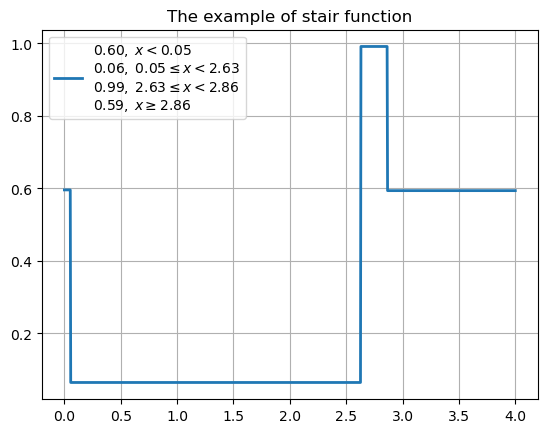

In [5]:
x0, x1 = 0, 4
n_stairs = 3
borders = x0 + (x1 - x0)*np.sort(np.random.random(n_stairs))
values = np.random.random(n_stairs + 1)

label = [r'${0:.2f}, \; {1:.2f} \leq x < {2:.2f}$'.format(values[i+1], 
                                                          borders[i], 
                                                          borders[i+1]) for i in range(n_stairs - 1)]
label = np.append(r'${0:.2f}, \; x < {1:.2f}$'.format(values[0], borders[0]), label)
label = np.append(label, r'${0:.2f}, \; x \geq {1:.2f}$'.format(values[-1], borders[-1]))
label = '\n'.join(label)

x = np.linspace(x0, x1, 1000)
y = stair_function(x, borders=borders, values=values)

plt.title('The example of stair function')
plt.plot(x, y, linewidth=2, label=label)
plt.legend()
plt.grid(True)
plt.show()

## Integral of stair function

For $\tau$ such that $\tau_i \leq \tau < \tau_{i+1}$ the integral of stair function $\nu$ will be:
$$
\int\limits_{\tau_0}^\tau \nu(t) dt = \sum\limits_{j=1}^i \nu_j(\tau_j - \tau_{j-1}) + \nu_{i+1}(\tau - \tau_i)
$$

In [6]:
def stair_integral(x0, x1, borders=[], values=[0], negative_backward=True):
    """
    """
    lengths_check(borders, values, raise_error=True)
    
    
    
    x1 = np.array(x1)
    x0 = x0*np.ones(x1.shape)
    
    borders_ = np.concatenate([[-np.inf], borders, [+np.inf]])
    
    ones = np.ones(np.append(len(borders_), x1.shape).astype(int))
    res = ones*borders_.reshape(np.append(len(borders_), np.ones(len(x1.shape))).astype(int))
    res[res < x0] = (x0*ones)[res < x0]
    res[res > x1] = (x1*ones)[res > x1]
    res = res[1:] - res[:-1]
    res = res*np.array(values).reshape(np.append(len(values), np.ones(len(res.shape) - 1)).astype(int))
    res = res.sum(axis=0)
    
    if negative_backward and (x0 > x1).any():
        res[x0 > x1] = -stair_integral(x0=x1[x0 > x1], x1=x0[x0 > x1], borders=borders, values=values)
        
    return res

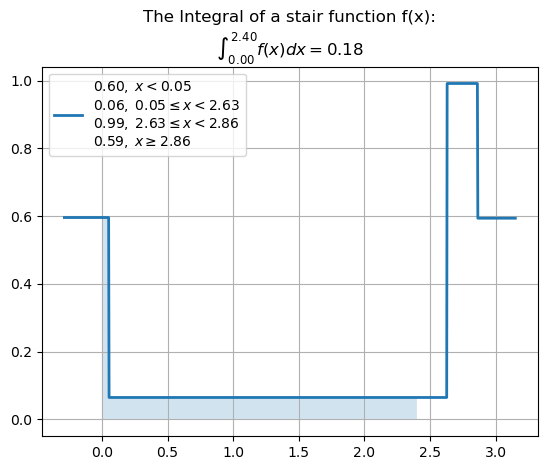

In [7]:
x0, x1 = 0, 2.4
int_val = stair_integral(x0, x1, borders=borders, values=values)

xl = np.append(x0, borders).min()
xr = np.append(x1, borders).max()
xl, xr = xl - 0.1*(xr - xl), xr + 0.1*(xr - xl)

x = np.linspace(xl, xr, 1000)
y = stair_function(x, borders=borders, values=values)

x_int = np.linspace(x0, x1, 1000)
y_int = stair_function(x_int, borders=borders, values=values)

title = 'The Integral of a stair function f(x):\n' 
title += r'$\int_{{{0:.2f}}}^{{{1:.2f}}} f(x) dx = {2:.2f}$'.format(x0, x1, int_val)

plt.title(title)
plt.plot(x, y, linewidth=2, label=label)
plt.fill_between(x_int, y_int, alpha=0.2)
plt.legend()
plt.grid(True)
plt.show()

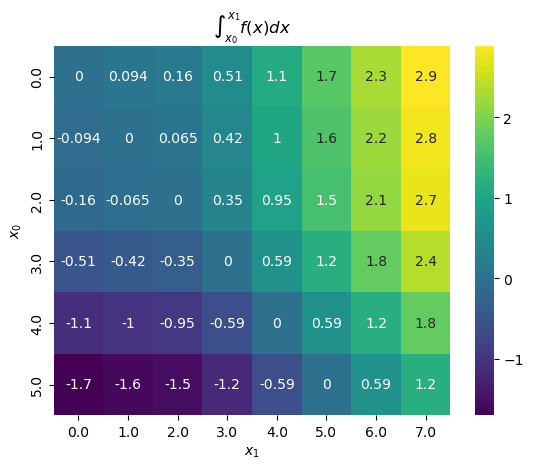

In [8]:
n = 6
m = 8
x0 = np.arange(n).reshape([n, 1])*np.ones([n, m])
x1 = np.arange(m).reshape([1, m])*np.ones([n, m])

int_vals = stair_integral(x0, x1, borders=borders, values=values)

plt.title(r'$\int_{x_0}^{x_1} f(x) dx$')
sns.heatmap(pd.DataFrame(int_vals, 
                         columns=pd.Index(x1[0], name='$x_1$'), 
                         index=pd.Index(x0[:, 0], name='$x_0$')), 
            annot=True, cmap='viridis')
plt.show()

# Define the slope patches

The slope patches are needed to understand the evolution of river profiles, given by formula
$$
\cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = \nu(\tau, \chi)
$$
where the function $\nu$ is $\chi$-independent stair function:
$$
\nu(\tau, \chi) = \nu(\tau) = 
\begin{cases}
\nu_0, \; \tau_0 \le \tau < \tau_1 \\
\nu_1, \; \tau_1 \le \tau < \tau_2 \\
... \\
\nu_i, \; \tau_{i} \le \tau < \tau_{i+1} \\
... \\
\nu_N, \; \tau_N \le \tau < \infty \\
\end{cases}
$$
we can just say, that $\nu_{N+1} = \infty$.

The concept of slope patches is described in the [article](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgrf.20031) by Leigh Royden and J. Taylor Perron.

Let's redefine the slope patches.
Let it be $N$ periods $[\tau_0, \tau_1)$, $[\tau_1, \tau_2)$, ..., $[\tau_N, \infty)$.

The $i$-th slope patch should be a segment of solution of an equation, associated with period $[\tau_i, \tau_{i+1})$, corresponding uplift rate $\nu_i$ and the slope value $\sigma_i = \nu_i^{1/n}$.

Let $\tau$ be in $[\tau_{i-1}, \tau_{i})$. So the equation will be look like
$$
\cfrac{\partial\lambda}{\partial\chi} = \nu_{i-1}^{1/n} = \sigma_{i-1}
$$
There will be a solution for $\tau_i$:
$$
\lambda(\tau_i, \chi) = \sigma_{i-1}\chi
$$
but in the moment $\tau_i$ the uplift rate changes to $\nu_i$ and so the slope value changes to $\sigma_i = \nu_i^{1/n}$ and remains constant until the moment $\tau_{i+1}$.
__This results in a new steady state river segment at the downstream end of the river, while the slope patch generated between $\tau_{i-1}$ and $\tau_{i}$ continues to migrate upstream.__
At time $\tau_f > \tau_{i+1}$ the elevation of section  

...

In [9]:
class SlopePatches:
    def __init__(self, patch_starts, uplift_rates, n):
        """
        Parameters:
        -----------
        patch_starts - float array length N > 0
            The times tau_i, when i-th patch starts
        
        uplift_rates - float array length N
            The values nu_i, uplift rate of the i-th patch (correspondes tau between tau_i and tau_{i+1})
        
        n - float
            The exponent on channel slope
        
        """
        if len(patch_starts) == 0:
            raise ValueError('The patch_starts should be not empty.')
        if len(patch_starts) != len(uplift_rates):
            msg = 'The arrays patch_starts and uplift_rates should be the same length. But:'
            msg += f'\nlen(patch_starts) = {len(patch_starts)}\nlen(uplift_rates) = {len(uplift_rates)}'
            raise ValueError(msg)
            
        self.patch_starts = np.array(patch_starts)
        self.uplift_rates = np.array(uplift_rates)
        self.n = float(n)
        
    
    def count(self):
        # returns the number of patchs
        return len(self.patch_starts)
    
    
    def get_slopes(self):
        #
        return self.uplift_rates**(1/self.n)
    
    def get_rights(self, tau):
        """
        """
        tau = np.array(tau)
        
        shape_res = np.append(self.count(), tau.shape).astype(int)
        shape_rat = shape_res.copy()
        shape_rat[1:] = 1
        shape_tau = shape_res.copy()
        shape_tau[0] = 1
        
        tau_use = tau.reshape(shape_tau)
        tau_use = tau_use - self.patch_starts.reshape(shape_rat)
        tau_use[tau_use < 0] = np.nan
        
        res = self.n*self.uplift_rates.reshape(shape_rat)**((self.n - 1)/self.n)*tau_use
        return res
    
    
    def get_lengths(self):
        """
        """
        res = self.n*self.uplift_rates**((self.n - 1)/self.n) 
        res *= np.append((self.patch_starts[1:] - self.patch_starts[:-1]), np.inf)
        return res
    
    
    def get_lefts(self, tau):
        """
        """
        tau = np.array(tau)
        
        rights = self.get_rights(tau)
        lengths = self.get_lengths()
        
        shape_res = np.array(rights.shape)
        shape_len = shape_res.copy()
        shape_len[1:] = 1
        
        res = rights - lengths.reshape(shape_len)
        res[res < 0] = 0
        return res
    
    
    def get_uplift_rate(self, tau, rate_before=np.nan):
        # returns the upluft rate (nu-value) for each moment tau
        return stair_function(tau, borders=self.patch_starts, values=np.append(rate_before, self.uplift_rates))
    
    
    def get_elevation(self, tau, chi):
        # Equation (B4)
        """
        """
        # tau and chi should be the same shape
        tau = np.array(tau)
        chi = np.array(chi)
        
        chi_left = self.get_lefts(tau)
        chi_right = self.get_rights(tau)
        chi_use = chi*np.ones(np.append(self.count(), chi.shape))
        chi_use[chi_use < chi_left] = np.nan
        chi_use[chi_use > chi_right] = np.nan
        chi_use[np.isnan(chi_left)] = np.nan
        chi_use[np.isnan(chi_right)] = np.nan
        
        lam_prechi = chi_use*self.get_slopes().reshape(np.append(self.count(), np.ones(chi.ndim, dtype=int)))
        
        lam_pretau = np.zeros(lam_prechi.shape)
        for i in range(self.count()):
            stair_values = np.append(0, self.uplift_rates - self.uplift_rates[i])
            lam_pretau[i] = stair_integral(x0=self.patch_starts[i], 
                                           x1=tau, 
                                           borders=self.patch_starts, 
                                           values=stair_values)
        lam = lam_prechi + lam_pretau
        return lam

In [10]:
patch_starts = [0, 1.5, 4, 8]
uplift_rates = [2, 0.5, 2, 0.5]

ns = [1, 2, 0.5]
slps = [SlopePatches(patch_starts, uplift_rates, n=n) for n in ns]

colors = [cm.turbo(i/(len(patch_starts) - 1)) for i in range(len(patch_starts))]

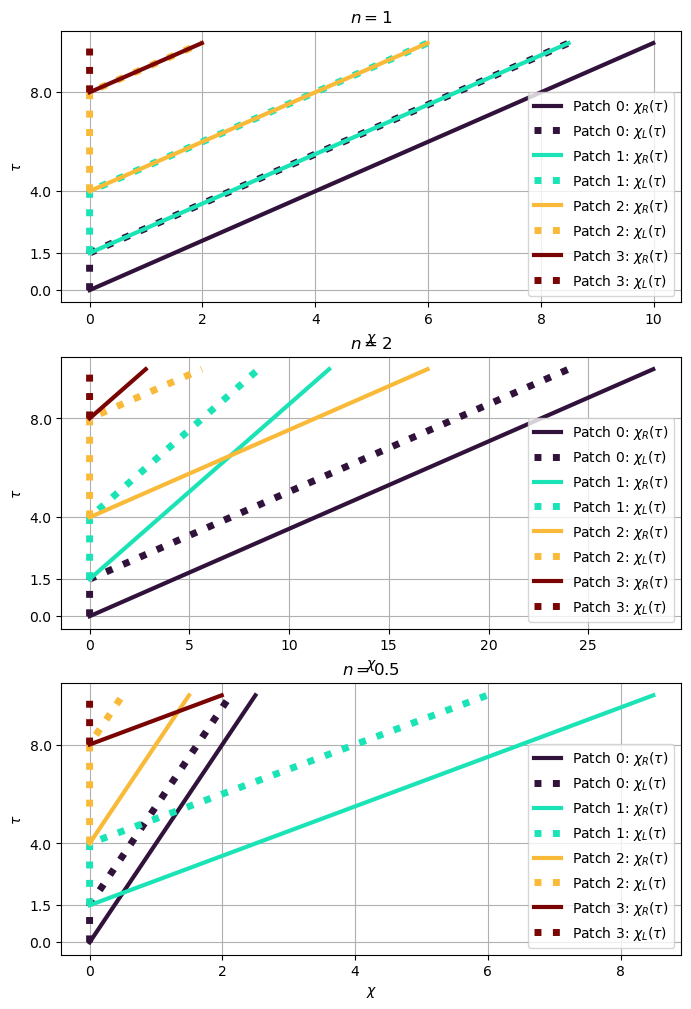

In [11]:
tau = np.arange(-1, 10, 0.01)


fig, axs = plt.subplots(len(ns))

fig.set_figheight(12)
fig.set_figwidth(8)

for ni, n in enumerate(ns):
    slp = slps[ni]

    rights = slp.get_rights(tau)
    lefts = slp.get_lefts(tau)

    for i in range(rights.shape[0]):
        axs[ni].plot(rights[i], tau, color=colors[i], 
                     linestyle='-', linewidth=3,
                     label=f"Patch {i}: $\\chi_R(\\tau)$")
        axs[ni].plot(lefts[i], tau, color=colors[i], 
                     linestyle=':', linewidth=5,
                     label=f"Patch {i}: $\\chi_L(\\tau)$")

    axs[ni].set_title(f'$n = {n}$')
    axs[ni].grid(True)
    axs[ni].legend()

    axs[ni].set_xlabel(r'$\chi$')
    axs[ni].set_ylabel(r'$\tau$')
    axs[ni].set_yticks(patch_starts)
plt.show()

In [12]:
ntau = 41
nchi = 41

tau_max = 10
chi_max = 10

tau = np.linspace(0, tau_max, ntau).reshape([ntau, 1])*np.ones([ntau, nchi])
chi = np.linspace(0, chi_max, nchi).reshape([1, nchi])*np.ones([ntau, nchi])

In [13]:
xticks = np.arange(0, ntau, 8)
xlabels = np.round(xticks/ntau*tau_max, 2)

yticks = np.arange(0, nchi, 8)
ylabels = np.round(yticks/nchi*chi_max, 2)


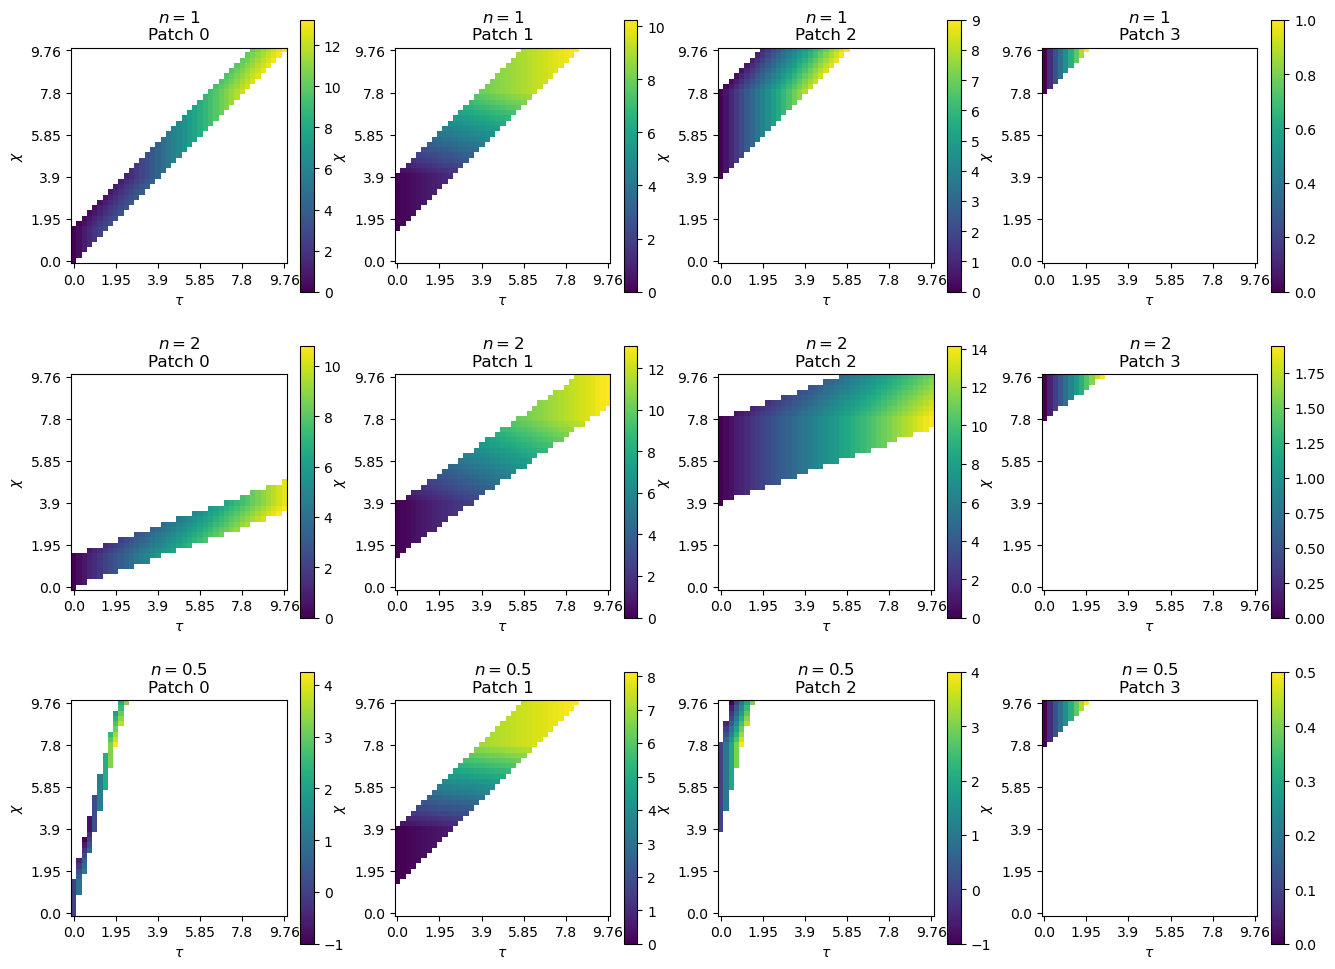

In [14]:
fig, axs = plt.subplots(len(ns), len(patch_starts))

fig.set_figwidth(16)
fig.set_figheight(12)

for ni, n in enumerate(ns):
    slp = slps[ni]
    lam = slp.get_elevation(tau, chi)
    for i in range(slp.count()):
        axs[ni, i].set_title(f'$n = {n}$\nPatch {i}')
        im = axs[ni, i].imshow(lam[i], origin='lower')
        plt.colorbar(im, orientation='vertical')
        
        axs[ni, i].set_xlabel(r'$\tau$')
        axs[ni, i].set_ylabel(r'$\chi$')
        axs[ni, i].set_xticks(xticks, xlabels)
        axs[ni, i].set_yticks(yticks, ylabels)
        
plt.show()

In [15]:
tau = np.linspace(0, 12, 601)
chi = np.linspace(0, 12, 601)

tau_space = np.ones([len(tau), len(chi)])*tau.reshape([len(tau), 1])
chi_space = np.ones([len(tau), len(chi)])*chi.reshape([1, len(chi)])

lam_spaces = np.array([slp.get_elevation(tau_space, chi_space) for slp in slps])

images = []

with tqdm(total=len(tau)) as pbar:
    for itau, tau in enumerate(tau):
        fig, axs = plt.subplots(len(slps))
        fig.set_figwidth(8)
        fig.set_figheight(12)

        fig.suptitle(r'$\tau = {0:.4f}$'.format(tau))
        
        for islp, slp in enumerate(slps):
            axs[islp].set_title('$n = {0}$'.format(slp.n))
        
            lam = lam_spaces[islp, :, itau, :]
            for i, ilam in enumerate(lam):
                axs[islp].plot(chi, ilam, label=f'patch {i}', color=colors[i], linewidth=2)
            axs[islp].legend()
            axs[islp].grid(True)
            axs[islp].set_xlabel(r'$\chi$')
            axs[islp].set_ylabel(r'$\lambda$')
        fig.canvas.draw()
        images.append(Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb()))
        fig.clear()
        plt.close('all')
        del fig
        
        pbar.update()

filename = 'gifs/patches.gif'
io.mimsave(filename, images, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/601 [00:00<?, ?it/s]

generated and saved to path gifs/patches.gif
